# Preparing Approximate GKP States using a GBS Device.

Term Paper MIT 6.S986 Silicon Photonics (Fall 2022). By Shoumik Chowdhury (@shoumikdc). 

Adapted from GKP simulations by I. Tzitrin and J. E. Bourassa. In this notebook, we numerically simulate the preparation of finite-energy Gottesman-Kitaev-Preskill (GKP) states using an optical circuit of tunable beamsplitters and squeezers. The target state is:  

$\left|0_\Delta\right> \approx S(0.196)[0.661\left|0\right> - 0.343\left|2\right> + 0.253\left|4\right>  - 0.368\left|6\right> + 0.377\left|8\right>  + 0.323\left|10\right>  + 0.365\left|12\right>]$,

which has 96.9% fidelity to the normalizable GKP state $\left|0_\Delta\right>$ for $\Delta = 10 \text{ dB}$. See [Phys. Rev. A 101, 032315 (2020)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.032315) and the blog post [Riding bosonic qubits towards fault-tolerant quantum computation](https://medium.com/xanaduai/riding-bosonic-qubits-towards-fault-tolerant-quantum-computation-95b92c78cb43) for more details. 

Here, we also benchmark how well the circuit performs when subjected to fab imperfections in the 2x2 coupler elements. 



In [1]:
import numpy as np
from qutip import wigner, Qobj, wigner_cmap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import strawberryfields as sf
from strawberryfields.ops import *
from thewalrus.quantum import state_vector, density_matrix

In [2]:
from bosonic import GKPQubit, plot_wigner

idealGKP = GKPQubit(params={"N":100, "delta": 0.3})
idealGKP.params["epsilon"]

0.3194725739184537

## Ideal Preparation

Here we setup some basic parameters, like the value of the photon-number-resolving detectors we will use to herald and the amount of squeezing and displacement to use. The origin of these parameters is discussed in the reference above.

In [3]:
m1, m2 = 5, 7
params = np.array([-1.38155106, -1.21699567,  0.7798817,  1.04182349,  
                   0.87702211, 0.90243916,  1.48353639,  1.6962906 , 
                   -0.24251599, 0.1958])
sq_r = params[:3]
bs_theta1, bs_theta2, bs_theta3 = params[3:6]
bs_phi1, bs_phi2, bs_phi3 = params[6:9]
sq_virt = params[9]

Now we setup a 3-mode quantum circuit in Strawberry Fields and obtain the covariance matrix and vector of means of the Gaussian state.

In [4]:
nmodes = 3
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")

with prog.context as q:
    for k in range(3):
        Sgate(sq_r[k]) | q[k]

    BSgate(np.pi/4, 0) | (q[0], q[1])
    Rgate(bs_theta1) | q[0]
    BSgate(np.pi/4, 0) | (q[0], q[1])
    Rgate(bs_phi1) | q[0]
    
    BSgate(np.pi/4, 0) | (q[1], q[2])
    Rgate(bs_theta2) | q[1]
    BSgate(np.pi/4, 0) | (q[1], q[2])
    Rgate(bs_phi2) | q[1]
    
    BSgate(np.pi/4, 0) | (q[0], q[1])
    Rgate(bs_theta3) | q[0]
    BSgate(np.pi/4, 0) | (q[0], q[1])
    Rgate(bs_phi3) | q[0]
    
    
    
#     BSgate(bs_theta1, bs_phi1) | (q[0], q[1])
#     BSgate(bs_theta2, bs_phi2) | (q[1], q[2])
#     BSgate(bs_theta3, bs_phi3) | (q[0], q[1])
    
    Sgate(sq_virt) | q[2]

state = eng.run(prog).state
mu, cov = state.means(), state.cov()

In [5]:
prog.draw_circuit()

['/Users/shoumikdc/crostini/6.976-Silicon-Photonics/Term Paper/circuit_tex/output_2022_December_14_11:30PM.tex',
 '\\documentclass{article}\n\\pagestyle{empty}\n\\usepackage{qcircuit}\n\\begin{document}\n\\Qcircuit {\n & \\gate{S}  & \\multigate{1}{BS}  & \\gate{R}  & \\multigate{1}{BS}  & \\gate{R}  & \\qw  & \\qw  & \\qw  & \\qw  & \\multigate{1}{BS}  & \\gate{R}  & \\multigate{1}{BS}  & \\gate{R}  & \\qw \\\\\n & \\gate{S}  & \\ghost{BS}  & \\qw  & \\ghost{BS}  & \\qw  & \\multigate{1}{BS}  & \\gate{R}  & \\multigate{1}{BS}  & \\gate{R}  & \\ghost{BS}  & \\qw  & \\ghost{BS}  & \\qw  & \\qw \\\\\n & \\gate{S}  & \\qw  & \\qw  & \\qw  & \\qw  & \\ghost{BS}  & \\qw  & \\ghost{BS}  & \\qw  & \\qw  & \\qw  & \\qw  & \\gate{S}  & \\qw \\\\\n}\n\\end{document}']

We can now inspect the covariance matrix and vector of means. Note that the vector of means is zero since we did not use displacement gates in the circuit above. This is due to the symmetry of the GKP wavefunction about the origin in phase space.

In [6]:
print(np.round(mu, 10))
print(np.round(cov, 10))

[0. 0. 0. 0. 0. 0.]
[[ 5.1540338   0.89466216  2.08336228  2.97365555 -2.8085551   0.4286188 ]
 [ 0.89466216  7.897538   -0.01416038 -0.72334939 -0.6911532  -7.28620617]
 [ 2.08336228 -0.01416038  3.72773407  0.62018826 -3.69218176  3.81092286]
 [ 2.97365555 -0.72334939  0.62018826  2.31515689 -1.04252728  0.54735133]
 [-2.8085551  -0.6911532  -3.69218176 -1.04252728  3.96352103 -2.9595734 ]
 [ 0.4286188  -7.28620617  3.81092286  0.54735133 -2.9595734  11.13510629]]


We now use The Walrus to obtain the Fock representation of the Gaussian state emerging in the 3rd mode when modes 1 and 2 are heralded in the values $n_1=5$ and $n_2=7$. We also calculate the probability of success in heralding the state.

In [7]:
cutoff = 100
psi = state_vector(mu, cov, post_select={0: m1, 1: m2}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi / p_psi
print('The probability of successful heralding is {:.5f}.'.format(p_psi ** 2))

The probability of successful heralding is 0.00102.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/shoumikdc/crostini/miniforge3/envs/xanadu/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
/Users/shoumikdc/crostini/miniforge3/envs/xanadu/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det


We now plot the photon-number distribution of the heralded state. Note that the state has zero support on the odd Fock states due to its symmetry, and the support tapers off after $n=8$.

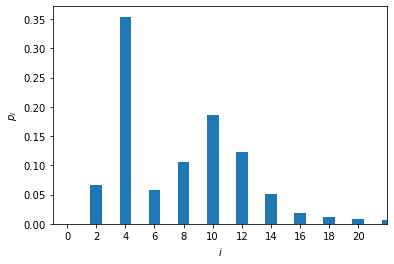

In [8]:
plt.bar(np.arange(cutoff), np.abs(psi) ** 2)
plt.xlim(-1, 22)
plt.xticks(np.arange(0, 22, 2))
plt.xlabel('$i$')
plt.ylabel(r'$p_i$')
plt.show()

We can now plot the Wigner function of the heralded state:

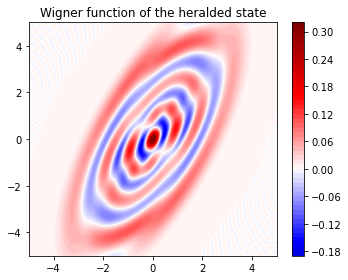

In [11]:
grid = 300
wigner_pts = np.linspace(-5,5, grid)

# plot_wigner(idealGKP.basis['+z'], wigner_pts, contour=False)
# ax = plt.gca()

Wp = wigner(Qobj(psi), wigner_pts, wigner_pts)
wmap = wigner_cmap(Wp)
sc1 = np.max(Wp)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
plt1 = axes.contourf(wigner_pts, wigner_pts, Wp, 60,  cmap=cm.seismic, norm=nrm)
axes.contour(wigner_pts, wigner_pts, Wp, 60,  cmap=cm.seismic, norm=nrm)
axes.set_title("Wigner function of the heralded state");
cb1 = fig.colorbar(plt1, ax=axes)
fig.tight_layout()
plt.show()

and a cut of the Wigner function along $p=0$.

In [ ]:
plt.plot(xvec, Wp[grid//2,:])
plt.title(r"$W(x,0)$")
plt.xlabel(r"q")
plt.show()

In [ ]:
np.abs(Qobj(psi).overlap(idealGKP.basis['+z']))**2

\begin{equation}
    U(\theta, \varphi) =\! \begin{bmatrix}
        e^{i\varphi}\sin(\frac{\theta}{2}) & e^{i\varphi}\cos(\frac{\theta}{2}) \\
        \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2})
    \end{bmatrix} = \begin{bmatrix}
        e^{i\varphi} & 0 \\ 0 & 1
    \end{bmatrix}\!\begin{bmatrix}
        t & ik \\ ik & t
    \end{bmatrix}\!\begin{bmatrix}
        e^{i\theta} & 0 \\ 0 & 1
    \end{bmatrix}\!\begin{bmatrix}
        t & ik \\ ik & t
    \end{bmatrix}
\end{equation}

\begin{equation}
    U(\theta, \varphi) =\! \begin{bmatrix}
        e^{i\varphi}\sin(\frac{\theta}{2}) & e^{i\varphi}\cos(\frac{\theta}{2}) \\
        \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2})
    \end{bmatrix} = \begin{bmatrix}
        e^{i\varphi} & 0 \\ 0 & 1
    \end{bmatrix}\!\begin{bmatrix}
        t & ik \\ ik & t
    \end{bmatrix}\!\begin{bmatrix}
        t e^{i\theta} & ike^{i\theta} \\ ik & t
    \end{bmatrix}
\end{equation}

\begin{equation}
    U(\theta, \varphi) =\! \begin{bmatrix}
        e^{i\varphi}\sin(\frac{\theta}{2}) & e^{i\varphi}\cos(\frac{\theta}{2}) \\
        \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2})
    \end{bmatrix} = \begin{bmatrix}
        e^{i\varphi} & 0 \\ 0 & 1
    \end{bmatrix}\!\begin{bmatrix}
        t^2 e^{i\theta} - k^2 & itk e^{i\theta} + itk \\ itke^{i\theta} + itk & t^2 - k^2 e^{i\theta}
    \end{bmatrix}
\end{equation}

\begin{equation}
    U(\theta, \varphi) = \begin{bmatrix}
        e^{i\varphi}\sin(\frac{\theta}{2}) & e^{i\varphi}\cos(\frac{\theta}{2}) \\
        \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2})
    \end{bmatrix} = \begin{bmatrix}
        i\sin(\frac{\theta}{2}) & i\cos(\frac{\theta}{2}) \\
        \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2}) 
    \end{bmatrix}
\end{equation}

In [ ]:
def random_GKP(ε):
    """
    For a given error ε multiplying the BS angles for the GKP circuit, 
    """
    
    m1, m2 = 5, 7 # Heralding photon numbers
    params = np.array([-1.38155106, -1.21699567,  0.7798817,  1.04182349,  
                       0.87702211, 0.90243916,  1.48353639,  1.6962906 , 
                       -0.24251599, 0.1958])
    sq_r = params[:3]
    params[3:9] = params[3:9] * np.random.uniform(1 - ε, 1 + ε, 6)
    bs_theta1, bs_theta2, bs_theta3 = params[3:6]
    bs_phi1, bs_phi2, bs_phi3 = params[6:9]
    sq_virt = params[9]
        
    nmodes = 3
    prog = sf.Program(nmodes)
    eng = sf.Engine("gaussian")

    with prog.context as q:
        for k in range(3):
            Sgate(sq_r[k]) | q[k]

        BSgate(bs_theta1, bs_phi1) | (q[0], q[1])
        BSgate(bs_theta2, bs_phi2) | (q[1], q[2])
        BSgate(bs_theta3, bs_phi3) | (q[0], q[1])

        Sgate(sq_virt) | q[2]

    state = eng.run(prog).state
    mu, cov = state.means(), state.cov()
        
    cutoff = 100
    psi = state_vector(mu, cov, post_select={0: m1, 1: m2}, normalize=False, cutoff=cutoff)
    p_psi = np.linalg.norm(psi)
    psi = psi / p_psi
    
    return np.abs(Qobj(psi).overlap(idealGKP.basis['+z']))**2

In [ ]:
# Official 
# counts, bins = np.histogram(x)
# plt.stairs(counts, bins)

# Or 
# plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
for ε in [0, 0.01, 0.02, 0.03, 0.04, 0.05]:

    fids = [random_GKP(ε) for i in range(100)]
    hist = np.histogram(fids, bins=25, range=(0, 1))
    plt.stairs(hist[0], hist[1], label=fr"$\varepsilon$ = {ε}")
    
plt.legend(loc="upper left")

In [ ]:
dir(sf.ops.BSgate)